In [1]:
import os,librosa
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers as opt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import losses
import pandas as pd

In [22]:
seed=42
n_MFCC=25
column_names= ['MFCC_'+str(i) for i in range(1,n_MFCC+1)]

In [23]:
DATA_PATH="/home/rakibul/WORK/Work/Thesis/Speech_Recognition/Vowel_Word/GitHub Repo/Vowel_Data/Vowel/"

In [24]:
def get_mfcc(file_path):
    wave, sr= librosa.load(file_path, mono=True, sr=None)
    mfcc=librosa.feature.mfcc(wave,sr=sr,n_mfcc=n_MFCC)
    mfcc_df=pd.DataFrame(mfcc.T,columns=column_names) #convert array to pandas df
    return mfcc_df

def get_all_mfcc(path=DATA_PATH):
    labels=sorted(os.listdir(path))
    all_mfcc=pd.DataFrame() #empty dataframe to store all_mfccs
    
    for label_index,label in enumerate(labels):
        folder_mfcc=pd.DataFrame() #empty dataframe to store mfcc of indivuals vowels/words i.e. folders

        speech_files=[path + label + '/' + file for file in sorted(os.listdir(path+'/'+label))]
        for file in tqdm(speech_files,"Reading Speech of label -'{}'".format(label)):
            #print(file)
            individual_mfcc=get_mfcc(file_path=file)
            folder_mfcc=folder_mfcc.append(individual_mfcc,ignore_index=True)
        
        folder_mfcc['label']=label_index  #new columns for encoding label
        
        all_mfcc=all_mfcc.append(folder_mfcc,ignore_index=True)
        
    return all_mfcc

def get_train_test(split_ratio=0.8,random_state=42):
    all_mfccs=get_all_mfcc()
    
    y=all_mfccs['label'].values
    
    only_mfcc=all_mfccs.drop(labels=['label'],axis=1)
    standard_mfcc=(only_mfcc-only_mfcc.mean())/only_mfcc.std()
    X=standard_mfcc.values

    assert X.shape[0] == len(y)
    return train_test_split(X,y,test_size=(1-split_ratio),random_state=random_state,shuffle=True,stratify=y)

In [25]:
X_train, X_test, y_train, y_test=get_train_test()
y_train_hot=to_categorical(y_train)
y_test_hot=to_categorical(y_test)

Reading Speech of label -'vowel7': 100%|██████████| 40/40 [00:00<00:00, 116.86it/s]


In [26]:
np.random.seed(seed)
model_v=Sequential()
model_v.add(Dense(128, activation='tanh',input_shape=(X_train.shape[1],)))
model_v.add(Dense(128, activation='tanh'))
model_v.add(Dense(64, activation='tanh'))
model_v.add(Dense(32, activation='tanh'))
model_v.add(Dense(16, activation='tanh'))
model_v.add(Dense(7, activation='softmax'))

In [27]:
model_v.compile(
    optimizer=opt.Adam(learning_rate=0.005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
    #metrics=['AUC']
)

In [28]:
history_v=model_v.fit(X_train, y_train_hot, epochs=300, batch_size=X_train.shape[0], validation_data=(X_test,y_test_hot))

Epoch 1/300
1/1 [==============================] - 0s 143ms/step - loss: 2.0087 - accuracy: 0.1353 - val_loss: 1.4044 - val_accuracy: 0.5879
Epoch 2/300
1/1 [==============================] - 0s 40ms/step - loss: 1.4052 - accuracy: 0.5848 - val_loss: 1.1754 - val_accuracy: 0.6721
Epoch 3/300
1/1 [==============================] - 0s 40ms/step - loss: 1.1785 - accuracy: 0.6719 - val_loss: 1.0554 - val_accuracy: 0.7079
Epoch 4/300
1/1 [==============================] - 0s 43ms/step - loss: 1.0587 - accuracy: 0.7090 - val_loss: 0.9688 - val_accuracy: 0.7384
Epoch 5/300
1/1 [==============================] - 0s 48ms/step - loss: 0.9708 - accuracy: 0.7331 - val_loss: 0.8998 - val_accuracy: 0.7558
Epoch 6/300
1/1 [==============================] - 0s 49ms/step - loss: 0.9004 - accuracy: 0.7571 - val_loss: 0.8441 - val_accuracy: 0.7742
Epoch 7/300
1/1 [==============================] - 0s 41ms/step - loss: 0.8438 - accuracy: 0.7719 - val_loss: 0.7972 - val_accuracy: 0.7868
Epoch 8/300
1/1 [==

1/1 [==============================] - 0s 54ms/step - loss: 0.0845 - accuracy: 0.9867 - val_loss: 0.1162 - val_accuracy: 0.9689
Epoch 60/300
1/1 [==============================] - 0s 69ms/step - loss: 0.0798 - accuracy: 0.9878 - val_loss: 0.1121 - val_accuracy: 0.9695
Epoch 61/300
1/1 [==============================] - 0s 55ms/step - loss: 0.0754 - accuracy: 0.9888 - val_loss: 0.1081 - val_accuracy: 0.9711
Epoch 62/300
1/1 [==============================] - 0s 44ms/step - loss: 0.0713 - accuracy: 0.9895 - val_loss: 0.1044 - val_accuracy: 0.9732
Epoch 63/300
1/1 [==============================] - 0s 38ms/step - loss: 0.0673 - accuracy: 0.9899 - val_loss: 0.1010 - val_accuracy: 0.9753
Epoch 64/300
1/1 [==============================] - 0s 38ms/step - loss: 0.0637 - accuracy: 0.9905 - val_loss: 0.0977 - val_accuracy: 0.9753
Epoch 65/300
1/1 [==============================] - 0s 38ms/step - loss: 0.0602 - accuracy: 0.9911 - val_loss: 0.0947 - val_accuracy: 0.9758
Epoch 66/300
1/1 [========

1/1 [==============================] - 0s 51ms/step - loss: 0.0093 - accuracy: 0.9996 - val_loss: 0.0468 - val_accuracy: 0.9900
Epoch 118/300
1/1 [==============================] - 0s 54ms/step - loss: 0.0091 - accuracy: 0.9996 - val_loss: 0.0467 - val_accuracy: 0.9900
Epoch 119/300
1/1 [==============================] - 0s 36ms/step - loss: 0.0090 - accuracy: 0.9996 - val_loss: 0.0466 - val_accuracy: 0.9900
Epoch 120/300
1/1 [==============================] - 0s 54ms/step - loss: 0.0088 - accuracy: 0.9996 - val_loss: 0.0465 - val_accuracy: 0.9900
Epoch 121/300
1/1 [==============================] - 0s 57ms/step - loss: 0.0086 - accuracy: 0.9996 - val_loss: 0.0464 - val_accuracy: 0.9900
Epoch 122/300
1/1 [==============================] - 0s 50ms/step - loss: 0.0085 - accuracy: 0.9996 - val_loss: 0.0463 - val_accuracy: 0.9900
Epoch 123/300
1/1 [==============================] - 0s 37ms/step - loss: 0.0083 - accuracy: 0.9996 - val_loss: 0.0461 - val_accuracy: 0.9900
Epoch 124/300
1/1 [=

Epoch 175/300
1/1 [==============================] - 0s 52ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.0434 - val_accuracy: 0.9900
Epoch 176/300
1/1 [==============================] - 0s 36ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.0434 - val_accuracy: 0.9900
Epoch 177/300
1/1 [==============================] - 0s 35ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.0434 - val_accuracy: 0.9900
Epoch 178/300
1/1 [==============================] - 0s 43ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.0434 - val_accuracy: 0.9900
Epoch 179/300
1/1 [==============================] - 0s 38ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.0434 - val_accuracy: 0.9900
Epoch 180/300
1/1 [==============================] - 0s 38ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.0433 - val_accuracy: 0.9895
Epoch 181/300
1/1 [==============================] - 0s 37ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.0433 - val_accuracy: 0.9895
Epoch 

Epoch 233/300
1/1 [==============================] - 0s 40ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0431 - val_accuracy: 0.9900
Epoch 234/300
1/1 [==============================] - 0s 37ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0431 - val_accuracy: 0.9900
Epoch 235/300
1/1 [==============================] - 0s 46ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0431 - val_accuracy: 0.9900
Epoch 236/300
1/1 [==============================] - 0s 53ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0431 - val_accuracy: 0.9900
Epoch 237/300
1/1 [==============================] - 0s 40ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0431 - val_accuracy: 0.9900
Epoch 238/300
1/1 [==============================] - 0s 35ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0431 - val_accuracy: 0.9900
Epoch 239/300
1/1 [==============================] - 0s 35ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0431 - val_accuracy: 0.9900
Epoch 

Epoch 291/300
1/1 [==============================] - 0s 46ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0433 - val_accuracy: 0.9905
Epoch 292/300
1/1 [==============================] - 0s 38ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0433 - val_accuracy: 0.9911
Epoch 293/300
1/1 [==============================] - 0s 36ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0433 - val_accuracy: 0.9911
Epoch 294/300
1/1 [==============================] - 0s 47ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0433 - val_accuracy: 0.9911
Epoch 295/300
1/1 [==============================] - 0s 43ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0433 - val_accuracy: 0.9911
Epoch 296/300
1/1 [==============================] - 0s 58ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0433 - val_accuracy: 0.9911
Epoch 297/300
1/1 [==============================] - 0s 35ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0433 - val_accuracy: 0.9911
Epoch 

In [30]:
history_dict_v=history_v.history

loss_v=history_dict_v['loss']
val_loss_v=history_dict_v['val_loss']

#auc_v=history_dict['auc']
#val_auc_v=history_dict['val_auc']

acc_v=history_dict_v['accuracy']
val_acc_v=history_dict_v['val_accuracy']

In [31]:
epochs=range(1,len(loss_v)+1)
ticks=[1]
ticks2=[i for i in range(30,len(loss_v)+1,30)]
ticks.extend(ticks2)

In [32]:
save_specifier='standard_mfcc_128_128_64_32_16_tanh_softmax_adam_005_batchfull_seed42'

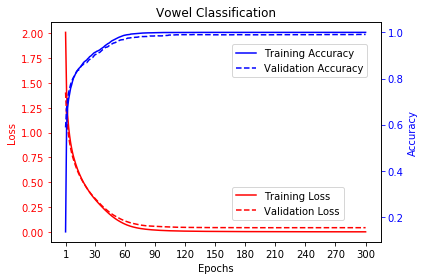

In [37]:
fig, ax=plt.subplots()
ln1=ax.plot(epochs,loss_v,'r', label='Training Loss')
ln2=ax.plot(epochs,val_loss_v,'r--', label='Validation Loss')

ax2=ax.twinx()
#ln3=ax2.plot(epochs,auc_v,'b', label='Training AUC')
#ln3=ax2.plot(epochs,val_auc_v,'b--', label='Validation AUC')

ln3=ax2.plot(epochs,acc_v,'b', label='Training Accuracy')
ln3=ax2.plot(epochs,val_acc_v,'b--', label='Validation Accuracy')

ax.set_title('Vowel Classification')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
#ax2.set_ylabel('AUC - ROC')
ax2.set_ylabel('Accuracy')

plt.xticks(ticks)
ax.legend(loc=(0.55,0.1))
ax2.legend(loc=(0.55,0.75))
#fig.legend(loc=(0.6,0.4))

ax.yaxis.label.set_color('red')
ax.tick_params(axis='y', colors='red')

ax2.yaxis.label.set_color('blue')
ax2.tick_params(axis='y', colors='blue')

plt.tight_layout()
plt.savefig('/home/rakibul/WORK/Work/Thesis/Speech_Recognition/Vowel_Word/GitHub Repo/Result/New_without_CNN/loss_auc_vowel_'+save_specifier+'.pdf',format='pdf', dpi=600)

In [38]:
DATA_PATH="/home/rakibul/WORK/Work/Thesis/Speech_Recognition/Vowel_Word/GitHub Repo/Word_Data/Word/"

In [39]:
def get_mfcc(file_path):
    wave, sr= librosa.load(file_path, mono=True, sr=None)
    mfcc=librosa.feature.mfcc(wave,sr=sr,n_mfcc=n_MFCC)
    mfcc_df=pd.DataFrame(mfcc.T,columns=column_names) #convert array to pandas df
    return mfcc_df

def get_all_mfcc(path=DATA_PATH):
    labels=sorted(os.listdir(path))
    all_mfcc=pd.DataFrame() #empty dataframe to store all_mfccs
    
    for label_index,label in enumerate(labels):
        folder_mfcc=pd.DataFrame() #empty dataframe to store mfcc of indivuals vowels/words i.e. folders

        speech_files=[path + label + '/' + file for file in sorted(os.listdir(path+'/'+label))]
        for file in tqdm(speech_files,"Reading Speech of label -'{}'".format(label)):
            #print(file)
            individual_mfcc=get_mfcc(file_path=file)
            folder_mfcc=folder_mfcc.append(individual_mfcc,ignore_index=True)
        
        folder_mfcc['label']=label_index  #new columns for encoding label
        
        all_mfcc=all_mfcc.append(folder_mfcc,ignore_index=True)
        
    return all_mfcc

def get_train_test(split_ratio=0.8,random_state=42):
    all_mfccs=get_all_mfcc()
    
    y=all_mfccs['label'].values
    
    only_mfcc=all_mfccs.drop(labels=['label'],axis=1)
    standard_mfcc=(only_mfcc-only_mfcc.mean())/only_mfcc.std()
    X=standard_mfcc.values

    assert X.shape[0] == len(y)
    return train_test_split(X,y,test_size=(1-split_ratio),random_state=random_state,shuffle=True,stratify=y)

In [40]:
X_train, X_test, y_train, y_test=get_train_test()
y_train_hot=to_categorical(y_train)
y_test_hot=to_categorical(y_test)

Reading Speech of label -'Word7': 100%|██████████| 40/40 [00:00<00:00, 95.45it/s] 


In [41]:
np.random.seed(seed)
model_w=Sequential()
model_w.add(Dense(128, activation='tanh',input_shape=(X_train.shape[1],)))
model_w.add(Dense(128, activation='tanh'))
model_w.add(Dense(64, activation='tanh'))
model_w.add(Dense(32, activation='tanh'))
model_w.add(Dense(16, activation='tanh'))
model_w.add(Dense(7, activation='softmax'))

In [42]:
model_w.compile(
    optimizer=opt.Adam(learning_rate=0.005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
    #metrics=['AUC']
)

In [43]:
history_w=model_w.fit(X_train, y_train_hot, epochs=300, batch_size=X_train.shape[0], validation_data=(X_test,y_test_hot))

Epoch 1/300
1/1 [==============================] - 0s 154ms/step - loss: 2.0766 - accuracy: 0.0954 - val_loss: 1.6946 - val_accuracy: 0.3769
Epoch 2/300
1/1 [==============================] - 0s 49ms/step - loss: 1.6921 - accuracy: 0.3898 - val_loss: 1.5523 - val_accuracy: 0.4563
Epoch 3/300
1/1 [==============================] - 0s 42ms/step - loss: 1.5533 - accuracy: 0.4714 - val_loss: 1.4768 - val_accuracy: 0.4840
Epoch 4/300
1/1 [==============================] - 0s 57ms/step - loss: 1.4781 - accuracy: 0.4944 - val_loss: 1.4292 - val_accuracy: 0.5016
Epoch 5/300
1/1 [==============================] - 0s 56ms/step - loss: 1.4286 - accuracy: 0.5095 - val_loss: 1.3951 - val_accuracy: 0.5092
Epoch 6/300
1/1 [==============================] - 0s 49ms/step - loss: 1.3914 - accuracy: 0.5201 - val_loss: 1.3668 - val_accuracy: 0.5176
Epoch 7/300
1/1 [==============================] - 0s 43ms/step - loss: 1.3602 - accuracy: 0.5333 - val_loss: 1.3419 - val_accuracy: 0.5160
Epoch 8/300
1/1 [==

1/1 [==============================] - 0s 38ms/step - loss: 0.4146 - accuracy: 0.8763 - val_loss: 0.5252 - val_accuracy: 0.8220
Epoch 60/300
1/1 [==============================] - 0s 37ms/step - loss: 0.4218 - accuracy: 0.8694 - val_loss: 0.5039 - val_accuracy: 0.8396
Epoch 61/300
1/1 [==============================] - 0s 41ms/step - loss: 0.3900 - accuracy: 0.8811 - val_loss: 0.5150 - val_accuracy: 0.8260
Epoch 62/300
1/1 [==============================] - 0s 68ms/step - loss: 0.3937 - accuracy: 0.8765 - val_loss: 0.4817 - val_accuracy: 0.8460
Epoch 63/300
1/1 [==============================] - 0s 79ms/step - loss: 0.3665 - accuracy: 0.8937 - val_loss: 0.4854 - val_accuracy: 0.8412
Epoch 64/300
1/1 [==============================] - 0s 51ms/step - loss: 0.3662 - accuracy: 0.8917 - val_loss: 0.4703 - val_accuracy: 0.8504
Epoch 65/300
1/1 [==============================] - 0s 46ms/step - loss: 0.3425 - accuracy: 0.9005 - val_loss: 0.4795 - val_accuracy: 0.8420
Epoch 66/300
1/1 [========

1/1 [==============================] - 0s 36ms/step - loss: 0.0597 - accuracy: 0.9923 - val_loss: 0.2979 - val_accuracy: 0.9106
Epoch 118/300
1/1 [==============================] - 0s 39ms/step - loss: 0.0572 - accuracy: 0.9929 - val_loss: 0.2972 - val_accuracy: 0.9130
Epoch 119/300
1/1 [==============================] - 0s 48ms/step - loss: 0.0555 - accuracy: 0.9935 - val_loss: 0.3005 - val_accuracy: 0.9118
Epoch 120/300
1/1 [==============================] - 0s 39ms/step - loss: 0.0538 - accuracy: 0.9932 - val_loss: 0.2958 - val_accuracy: 0.9114
Epoch 121/300
1/1 [==============================] - 0s 39ms/step - loss: 0.0519 - accuracy: 0.9938 - val_loss: 0.2978 - val_accuracy: 0.9138
Epoch 122/300
1/1 [==============================] - 0s 43ms/step - loss: 0.0502 - accuracy: 0.9947 - val_loss: 0.2962 - val_accuracy: 0.9110
Epoch 123/300
1/1 [==============================] - 0s 41ms/step - loss: 0.0489 - accuracy: 0.9948 - val_loss: 0.2997 - val_accuracy: 0.9138
Epoch 124/300
1/1 [=

Epoch 175/300
1/1 [==============================] - 0s 38ms/step - loss: 0.0130 - accuracy: 0.9996 - val_loss: 0.3091 - val_accuracy: 0.9134
Epoch 176/300
1/1 [==============================] - 0s 37ms/step - loss: 0.0127 - accuracy: 0.9997 - val_loss: 0.3099 - val_accuracy: 0.9130
Epoch 177/300
1/1 [==============================] - 0s 43ms/step - loss: 0.0125 - accuracy: 0.9998 - val_loss: 0.3098 - val_accuracy: 0.9138
Epoch 178/300
1/1 [==============================] - 0s 58ms/step - loss: 0.0122 - accuracy: 0.9998 - val_loss: 0.3099 - val_accuracy: 0.9146
Epoch 179/300
1/1 [==============================] - 0s 51ms/step - loss: 0.0120 - accuracy: 0.9998 - val_loss: 0.3110 - val_accuracy: 0.9146
Epoch 180/300
1/1 [==============================] - 0s 37ms/step - loss: 0.0118 - accuracy: 0.9998 - val_loss: 0.3113 - val_accuracy: 0.9146
Epoch 181/300
1/1 [==============================] - 0s 36ms/step - loss: 0.0116 - accuracy: 0.9998 - val_loss: 0.3107 - val_accuracy: 0.9146
Epoch 

Epoch 233/300
1/1 [==============================] - 0s 49ms/step - loss: 0.0055 - accuracy: 1.0000 - val_loss: 0.3262 - val_accuracy: 0.9126
Epoch 234/300
1/1 [==============================] - 0s 39ms/step - loss: 0.0054 - accuracy: 1.0000 - val_loss: 0.3265 - val_accuracy: 0.9126
Epoch 235/300
1/1 [==============================] - 0s 44ms/step - loss: 0.0054 - accuracy: 1.0000 - val_loss: 0.3267 - val_accuracy: 0.9126
Epoch 236/300
1/1 [==============================] - 0s 38ms/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.3269 - val_accuracy: 0.9122
Epoch 237/300
1/1 [==============================] - 0s 40ms/step - loss: 0.0052 - accuracy: 1.0000 - val_loss: 0.3272 - val_accuracy: 0.9122
Epoch 238/300
1/1 [==============================] - 0s 39ms/step - loss: 0.0052 - accuracy: 1.0000 - val_loss: 0.3274 - val_accuracy: 0.9122
Epoch 239/300
1/1 [==============================] - 0s 41ms/step - loss: 0.0051 - accuracy: 1.0000 - val_loss: 0.3277 - val_accuracy: 0.9122
Epoch 

Epoch 291/300
1/1 [==============================] - 0s 43ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.3384 - val_accuracy: 0.9134
Epoch 292/300
1/1 [==============================] - 0s 39ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.3386 - val_accuracy: 0.9134
Epoch 293/300
1/1 [==============================] - 0s 44ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.3388 - val_accuracy: 0.9134
Epoch 294/300
1/1 [==============================] - 0s 39ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.3390 - val_accuracy: 0.9138
Epoch 295/300
1/1 [==============================] - 0s 40ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.3391 - val_accuracy: 0.9138
Epoch 296/300
1/1 [==============================] - 0s 38ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.3393 - val_accuracy: 0.9142
Epoch 297/300
1/1 [==============================] - 0s 38ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.3395 - val_accuracy: 0.9142
Epoch 

In [45]:
history_dict_w=history_w.history
loss_w=history_dict_w['loss']
val_loss_w=history_dict_w['val_loss']

#auc_w=history_dict['auc']
#val_auc_w=history_dict['val_auc']

acc_v=history_dict_v['accuracy']
val_acc_v=history_dict_v['val_accuracy']

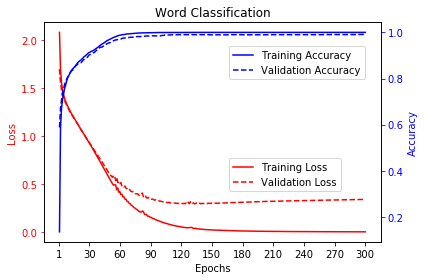

In [47]:
fig, ax=plt.subplots()
ln1=ax.plot(epochs,loss_w,'r', label='Training Loss')
ln2=ax.plot(epochs,val_loss_w,'r--', label='Validation Loss')

ax2=ax.twinx()
#ln3=ax2.plot(epochs,auc_w,'b', label='Training AUC')
#ln3=ax2.plot(epochs,val_auc_w,'b.', label='Validation AUC')

ln3=ax2.plot(epochs,acc_v,'b', label='Training Accuracy')
ln3=ax2.plot(epochs,val_acc_v,'b--', label='Validation Accuracy')

ax.set_title('Word Classification')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
#ax2.set_ylabel('AUC - ROC')
ax2.set_ylabel('Accuracy')

plt.xticks(ticks)
ax.legend(loc=(0.55,0.23))
ax2.legend(loc=(0.55,0.74))
#fig.legend(loc=(0.6,0.4))

ax.yaxis.label.set_color('red')
ax.tick_params(axis='y', colors='red')

ax2.yaxis.label.set_color('blue')
ax2.tick_params(axis='y', colors='blue')

plt.tight_layout()
plt.savefig('/home/rakibul/WORK/Work/Thesis/Speech_Recognition/Vowel_Word/GitHub Repo/Result/New_without_CNN/loss_auc_word_'+save_specifier+'.pdf',format='pdf', dpi=600)

In [59]:
#COMPARE

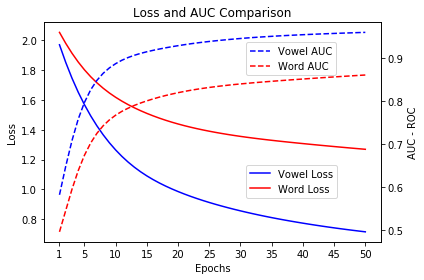

In [60]:
fig, ax=plt.subplots()
ln1=ax.plot(epochs,loss_v,'b', label='Vowel Loss')
ln2=ax.plot(epochs,loss_w,'r', label='Word Loss')

ax2=ax.twinx()
ln3=ax2.plot(epochs,auc_v,'b--', label='Vowel AUC')
ln3=ax2.plot(epochs,auc_w,'r--', label='Word AUC')

ax.set_title('Loss and AUC Comparison')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax2.set_ylabel('AUC - ROC')

plt.xticks(ticks)
ax.legend(loc=(0.6,0.2))
ax2.legend(loc=(0.6,0.76))
#fig.legend(loc=(0.6,0.4))
plt.tight_layout()
plt.savefig('./New_without_CNN/comare_'+save_specifier+'.pdf',format='pdf', dpi=600)

In [61]:
all_compare_df=pd.DataFrame({'loss_v':loss_v,
                      'val_loss_v':val_loss_v,
                      'auc_v':auc_v,
                      'val_auc_v':val_auc_v,
                      'loss_w':loss_w,
                      'val_loss_w':val_loss_w,
                      'auc_w':auc_w,
                      'val_auc_w':val_auc_w
                     })

all_compare_df.to_csv('./New_without_CNN/all_compare_data_'+save_specifier+'.csv')

In [67]:
all_compare_df.tail()

,loss_v,val_loss_v,acc_v,val_acc_v,auc_v,val_auc_v,loss_w,val_loss_w,acc_w,val_acc_w,auc_w,val_auc_w
45,1.087982,1.079178,0.578892,0.576316,0.914252,0.914130,1.465496,1.461363,0.433841,0.435846,0.808475,0.810116
46,1.073246,1.063786,0.580471,0.586316,0.916134,0.916380,1.460930,1.456924,0.435345,0.437049,0.809607,0.811218
47,1.058198,1.051638,0.585735,0.577368,0.918239,0.917834,1.456578,1.452782,0.435445,0.443865,0.810850,0.812264
48,1.043170,1.040124,0.585867,0.578421,0.920454,0.919898,1.452407,1.448659,0.439755,0.447875,0.812117,0.813237
49,1.030735,1.028717,0.590604,0.581053,0.922445,0.921268,1.448298,1.444540,0.444968,0.446672,0.813397,0.814203


In [45]:
all_compare_df.tail()

,loss_v,val_loss_v,acc_v,val_acc_v,auc_v,val_auc_v,loss_w,val_loss_w,acc_w,val_acc_w,auc_w,val_auc_w
45,0.747012,0.753977,0.741413,0.727895,0.960994,0.959738,1.281573,1.291772,0.509824,0.504010,0.859364,0.856465
46,0.740706,0.747679,0.742203,0.727895,0.961514,0.960330,1.277932,1.287836,0.511628,0.503609,0.860304,0.857371
47,0.734629,0.741603,0.743387,0.728421,0.961970,0.960810,1.274361,1.283999,0.512831,0.503609,0.861195,0.858353
48,0.728761,0.735736,0.745493,0.731053,0.962445,0.961305,1.270858,1.280256,0.513031,0.506816,0.862042,0.859321
49,0.723083,0.730062,0.745756,0.734211,0.962883,0.961810,1.267420,1.276603,0.514635,0.510024,0.862903,0.860176


In [28]:
all_compare_df.tail()

,loss_v,val_loss_v,auc_v,val_auc_v,loss_w,val_loss_w,auc_w,val_auc_w
45,0.706936,0.714525,0.963838,0.962377,1.309307,1.312979,0.854070,0.852646
46,0.701005,0.709404,0.964249,0.962680,1.304894,1.309166,0.855060,0.853603
47,0.695289,0.704458,0.964672,0.963047,1.300554,1.305393,0.856125,0.854472
48,0.689775,0.699667,0.965066,0.963378,1.296285,1.301660,0.857146,0.855276
49,0.684449,0.695019,0.965437,0.963702,1.292087,1.297965,0.858121,0.855980


In [62]:
all_compare_df.tail()

,loss_v,val_loss_v,auc_v,val_auc_v,loss_w,val_loss_w,auc_w,val_auc_w
45,0.735822,0.740672,0.958826,0.957656,1.283517,1.293495,0.857910,0.855152
46,0.730334,0.735616,0.959333,0.958082,1.279773,1.289651,0.858789,0.856155
47,0.725022,0.730728,0.959823,0.958516,1.276084,1.285892,0.859699,0.856994
48,0.719872,0.725991,0.960334,0.958967,1.272452,1.282220,0.860599,0.857870
49,0.714867,0.721389,0.960773,0.959409,1.268873,1.278631,0.861462,0.858814
